# 임포트

In [21]:
import torch
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn as nn
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
from scipy.optimize import fsolve
import math
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from tqdm import tqdm
from PIL import Image

from Func import * # 별: all

# 하이퍼 파라미터 정의

In [22]:
USE_CUDA= torch.cuda.is_available()
DEVICE= torch.device("cuda"if USE_CUDA else "cpu")
print("다음 기기로 학습합니다: ", DEVICE)

random.seed(42)
torch.manual_seed(42)
if DEVICE == 'cuda':
    torch.cuda.manual_seed_all(42)

BATCH_SIZE = 16
LR = 1e-3
LR_STEP = 3
LR_GAMMA = 0.9
EPOCH = 100
TRAIN_RATIO = 0.6
VAL_RATIO = 0.8
criterion = nn.MSELoss().to(DEVICE)
new_model_train = False
base_model="MLP"
model_type = "PINN"
version = "ver5"
ep=f"EP{EPOCH}"
etc="_0703"
save_model_path = f"../model/{model_type}_{version}_{ep}{etc}.pt"
load_model_path = save_model_path
save_history_path = f"../history/{model_type}_history_{version}_{ep}{etc}.pt"
load_history_path=save_history_path
image_save=False
save_loss_path = f"../image/loss/{model_type}_loss_{version}_{ep}{etc}.png"
save_full_pred_path = f"../image/pred/{model_type}_fullpred_{version}_{ep}{etc}.png"
save_day_pred_path = f"../image/pred/{model_type}_0625pred_{version}_{ep}{etc}.png"

다음 기기로 학습합니다:  cpu


# 모델 정의

In [23]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        linear1= nn.Linear(12, 72)
        linear2= nn.Linear(72, 120)
        linear3= nn.Linear(120, 60)
        linear4= nn.Linear(60, 1)
        
        nn.init.xavier_uniform_(linear1.weight)
        nn.init.xavier_uniform_(linear2.weight)
        nn.init.xavier_uniform_(linear3.weight)
        nn.init.xavier_uniform_(linear4.weight)

        activ=nn.ELU()
        
        self.linear = nn.Sequential(linear1, activ,
                                    linear2, activ,
                                    linear3, activ,
                                    linear4)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.linear(x)
        return x

# 데이터 준비

In [24]:
# 사전 작업: 데이터에 NaN값을 빈칸으로 바꾸기(1022개)
path = '../../data/data_for_model_1.csv'
data = pd.read_csv(path)

# 데이터 중 NULL 값 있는지 확인
len(data)-data.count()

#무의미한 특성 2개 제거
data = data.drop(['Unnamed: 0'], axis = 1)
#data = data.drop(['Unnamed: 15'], axis = 1)
data = data.drop(['date'], axis = 1)
data.info()

#기존 값에 뭔가 영향을 줄까봐 복사하기
# Wind speed에 Null값이 있어서 Null값이 있는 행 제거 (앞뒤 값의 평균으로 대체하려다가 실패: Null이 연속으로 있는 경우가 있음)
# Wind speed에 Type이 object라서 float64로 변경
Rail = data.copy()
Rail_del_row = Rail.dropna(subset = ["wind_speed"])
Rail_del_row = Rail_del_row.astype({'wind_speed':'float64'})
data_real_scale=Rail_del_row[:len(Rail_del_row)-4]


# 각 값의 크기가 달라서 MinMaxScaler
dmin=data_real_scale.min()
dmax=data_real_scale.max()
Rail_ready= (data_real_scale-dmin)/(dmax-dmin)
# Rail_ready= data_real_scale ## scaling 안하기


# 입력변수와 출력값 분리
X = Rail_ready.iloc[:, :12]
Y = Rail_ready.iloc[:,12]


# Dataframe으로 되어있는 값을 계산을 위해 array로 변경
X_np= X.values
Y_np= Y.values

X_t, Y_t= torch.tensor(X_np, dtype=torch.float32), torch.tensor(Y_np, dtype=torch.float32).view(-1,1)

X_train, X_val, X_test = X_t[:int(len(X_t)*TRAIN_RATIO)], X_t[int(len(X_t)*TRAIN_RATIO):int(len(X_t)*VAL_RATIO)] ,X_t[int(len(X_t)*VAL_RATIO):]
Y_train, Y_val, Y_test = Y_t[:int(len(Y_t)*TRAIN_RATIO)], Y_t[int(len(Y_t)*TRAIN_RATIO):int(len(Y_t)*VAL_RATIO)] ,Y_t[int(len(Y_t)*VAL_RATIO):]

X_0=X_train[0].numpy()
Y_0=Y_train[0].numpy()

train_set=TensorDataset(X_train[1:], Y_train[1:])
val_set=TensorDataset(X_val, Y_val)
test_set=TensorDataset(X_test, Y_test)

train_loader=DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=False)
val_loader=DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False) 
test_loader=DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96392 entries, 0 to 96391
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   air_temp        96392 non-null  float64
 1   TSI             96392 non-null  float64
 2   azimuth         96392 non-null  float64
 3   altitude        96392 non-null  float64
 4   solar_rad       96392 non-null  int64  
 5   High_solar_rad  96392 non-null  int64  
 6   casi            96392 non-null  int64  
 7   humidity        96392 non-null  int64  
 8   rain            96392 non-null  float64
 9   wind_speed      95366 non-null  float64
 10  wind_direction  96392 non-null  float64
 11  rail_direction  96392 non-null  int64  
 12  rail_temp       96392 non-null  float64
 13  Unnamed: 15     5 non-null      float64
dtypes: float64(9), int64(5)
memory usage: 10.3 MB


# 모델 훈련

In [25]:
random.seed(42)
torch.manual_seed(42)
if DEVICE == 'cuda':
    torch.cuda.manual_seed_all(42)

exec(f"model = {base_model}().to(DEVICE)") # exec: 문자열을 코드로 인식하게 함. 단, 실행전에는 코드로 인식해서 모델을 정의한 사실을 코드에서 몰라서 오류문구를 띄울 수 있음
model=model
print(model)
x_batch, _ = next(iter(train_loader))
print(model(x_batch.to(DEVICE)).shape)

if new_model_train:
    optimizer = optim.Adam(model.parameters(), lr=LR)
    loss_history = Train(model,model_type, train_loader, val_loader, criterion, optimizer, 
          EPOCH, BATCH_SIZE, TRAIN_RATIO,
          save_model_path, save_history_path, d_max=dmax, d_min=dmin)
    fin_save_model_path=save_model_path[:-3]+"_FIN"+save_model_path[-3:]
    torch.save(model, fin_save_model_path)

MLP(
  (linear): Sequential(
    (0): Linear(in_features=12, out_features=72, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=72, out_features=120, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=120, out_features=60, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=60, out_features=1, bias=True)
  )
)
torch.Size([16, 1])


# 모델 Load하기

In [26]:
model_load = torch.load(load_model_path, map_location=DEVICE)
load_history = torch.load(load_history_path, map_location=DEVICE)
print(model_load)

{'model': MLP(
  (linear): Sequential(
    (0): Linear(in_features=12, out_features=72, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=72, out_features=120, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=120, out_features=60, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=60, out_features=1, bias=True)
  )
), 'ep': 11, 'optimizer': Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
), 'scheduler': None}


# 모델 평가하기

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


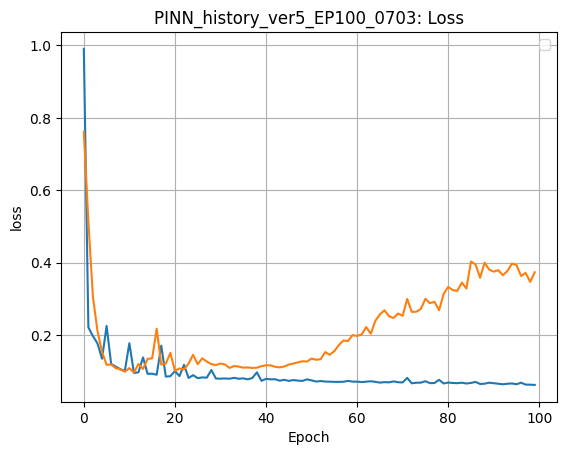

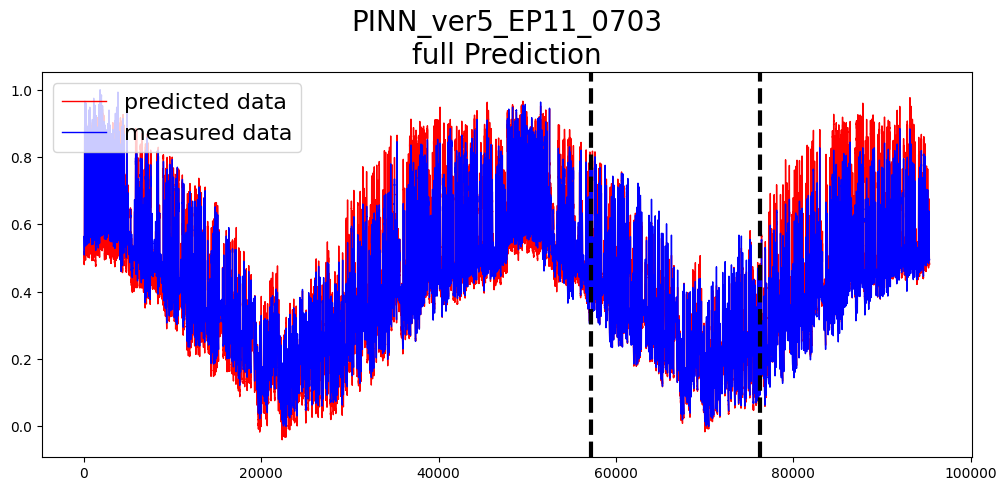

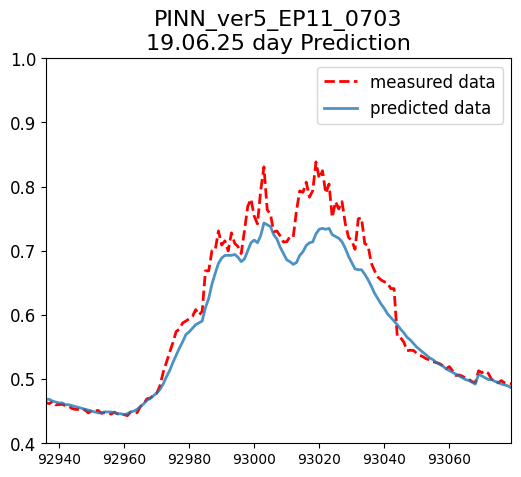

In [27]:
list_train=[]; list_val=[]
for _ in load_history['loss_history']['train']:
    list_train.append(_.item())
for _ in load_history['loss_history']['val']:
    list_val.append(_.item()) 

plt.plot(list_train)
plt.plot(list_val)
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title(f"{model_type}_history_{version}_{ep}{etc}: Loss")
plt.legend()
plt.grid()
if image_save:
    plt.savefig(save_loss_path)

with torch.no_grad():
    model_load['model'].eval()
    pred=model_load['model'](X_t.to(DEVICE))
    pred=pred.cpu().detach().numpy()
    
plt.figure(figsize=(12,5))
plt.plot(pred, color='red', alpha=1,linewidth=1,  label='predicted data')
plt.plot(Y_np, color='blue', alpha=1, linewidth=1, label='measured data')
plt.legend(loc='upper left',fontsize=16)
plt.axvline(x=len(pred)*TRAIN_RATIO, color='black', linestyle='--', linewidth=3)
plt.axvline(x=len(pred)*VAL_RATIO, color='black', linestyle='--', linewidth=3)
plt.title(f"{model_type}_{version}_{ep[:2]}{model_load['ep']}{etc}\nfull Prediction",fontsize=20) 
if image_save:
    plt.savefig(save_full_pred_path)
    
plt.figure(figsize=(6,5))
plt.plot(pred,'r--',linewidth=2, label='measured data')
plt.plot(Y_np, linewidth=2, alpha=0.8, label='predicted data')
plt.legend(fontsize=12)
plt.xlim(92936,93079)
plt.ylim(0.4, 1)
plt.title(f"{model_type}_{version}_{ep[:2]}{model_load['ep']}{etc}\n19.06.25 day Prediction",fontsize=16) 
#plt.xticks([2880,2898,2916,2934,2952,2970,2988,3004,3023],labels=['00:00','03:00','06:00' ,'09:00','12:00','15:00','18:00','21:00', '00:00'],fontsize=12, rotation=45)
plt.yticks(fontsize=12)
if image_save:
    plt.savefig(save_day_pred_path)

In [28]:
with torch.no_grad():
    model_load['model'].eval()
    pred_train=model_load['model'](X_train.to(DEVICE)).cpu()
    pred_val=model_load['model'](X_val.to(DEVICE)).cpu()
    pred_test=model_load['model'](X_test.to(DEVICE)).cpu()

#pred={"train":["r2":[],"mae":[],"mse":[]], "val":["r2":[],"mae":[],"mse":[]]}

train_pred = {"r2":[],"mae":[],"mse":[]}
val_pred = {"r2":[],"mae":[],"mse":[]}
test_pred = {"r2":[],"mae":[],"mse":[]}

print("train")
print("R2 =",r2_score(Y_train, pred_train.detach().numpy()))
print("mae =",torch.from_numpy(np.array(mean_absolute_error(Y_train, pred_train.detach().numpy()))).item())
print("mse =",torch.from_numpy(np.array(mean_squared_error(Y_train, pred_train.detach().numpy()))).item())
print("mape", torch.from_numpy(np.array(mean_absolute_percentage_error(Y_train, pred_train.detach().numpy()))).item())

print("val")
print("R2 =",r2_score(Y_val, pred_val.detach().numpy()))
print("mae =",torch.from_numpy(np.array(mean_absolute_error(Y_val, pred_val.detach().numpy()))).item())
print("mse =",torch.from_numpy(np.array(mean_squared_error(Y_val, pred_val.detach().numpy()))).item())
print("mape", torch.from_numpy(np.array(mean_absolute_percentage_error(Y_val, pred_val.detach().numpy()))).item())

print("test")
print("R2 =",r2_score(Y_test, pred_test.detach().numpy()))
print("mae =",torch.from_numpy(np.array(mean_absolute_error(Y_test, pred_test.detach().numpy()))).item())
print("mse =",torch.from_numpy(np.array(mean_squared_error(Y_test, pred_test.detach().numpy()))).item())
print("mape", torch.from_numpy(np.array(mean_absolute_percentage_error(Y_test, pred_test.detach().numpy()))).item())

# 추가해야할 것: 각 퍼포먼스를 판다스를 이용하고 csv파일로 저장하기

train
R2 = 0.959645595343526
mae = 0.032807521522045135
mse = 0.0017256928840652108
mape 2464074240.0
val
R2 = 0.9739042661260381
mae = 0.015445660799741745
mse = 0.0006079758750274777
mape 8236926976.0
test
R2 = 0.8380259777834216
mae = 0.04719093069434166
mse = 0.004405535291880369
mape 0.10161171853542328


# 원하는 모델 불러와서 확인하기

In [29]:
'''
model_name="PINN_ver5_EP100_0703+FIN"
history_name=model_name[:4]+"_history"+model_name[4:-4]

load_model_path = f"../model/{model_name}.pt"
load_hitsory_path= f"../history/{history_name}.pt"

model_load = torch.load(load_model_path, map_location=DEVICE)
load_history = torch.load(load_hitsory_path, map_location=DEVICE)

list_train=[]; list_val=[]
for _ in load_history['loss_history']['train']:
    list_train.append(_.item())
for _ in load_history['loss_history']['val']:
    list_val.append(_.item()) 

plt.plot(list_train)
plt.plot(list_val)
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title(f"{history_name}: Loss")
plt.legend()
plt.grid()



with torch.no_grad():
    model_load.eval()
    pred=model_load(X_t.to(DEVICE))
    pred=pred.cpu().detach().numpy()
    
plt.figure(figsize=(12,5))
plt.plot(pred, color='red', alpha=1,linewidth=1,  label='predicted data')
plt.plot(Y_np, color='blue', alpha=0.5, linewidth=1, label='measured data')
plt.legend(loc='lower left',fontsize=16)
plt.axvline(x=len(pred)*TRAIN_RATIO, color='black', linestyle='--', linewidth=3)
plt.axvline(x=len(pred)*VAL_RATIO, color='black', linestyle='--', linewidth=3)
plt.title(f"{model_name}: Prediction",fontsize=20)

with torch.no_grad():
    model_load.eval()
    pred_train=model_load(X_train.to(DEVICE)).cpu()
    pred_val=model_load(X_val.to(DEVICE)).cpu()
    pred_test=model_load(X_test.to(DEVICE)).cpu()

#pred={"train":["r2":[],"mae":[],"mse":[]], "val":["r2":[],"mae":[],"mse":[]]}

train_pred = {"r2":[],"mae":[],"mse":[]}
val_pred = {"r2":[],"mae":[],"mse":[]}
test_pred = {"r2":[],"mae":[],"mse":[]}

print("train")
print("R2 =",r2_score(Y_train, pred_train.detach().numpy()))
print("mae =",torch.from_numpy(np.array(mean_absolute_error(Y_train, pred_train.detach().numpy()))).item())
print("mse =",torch.from_numpy(np.array(mean_squared_error(Y_train, pred_train.detach().numpy()))).item())
print("mape", torch.from_numpy(np.array(mean_absolute_percentage_error(Y_train, pred_train.detach().numpy()))).item())

print("val")
print("R2 =",r2_score(Y_val, pred_val.detach().numpy()))
print("mae =",torch.from_numpy(np.array(mean_absolute_error(Y_val, pred_val.detach().numpy()))).item())
print("mse =",torch.from_numpy(np.array(mean_squared_error(Y_val, pred_val.detach().numpy()))).item())
print("mape", torch.from_numpy(np.array(mean_absolute_percentage_error(Y_val, pred_val.detach().numpy()))).item())

print("test")
print("R2 =",r2_score(Y_test, pred_test.detach().numpy()))
print("mae =",torch.from_numpy(np.array(mean_absolute_error(Y_test, pred_test.detach().numpy()))).item())
print("mse =",torch.from_numpy(np.array(mean_squared_error(Y_test, pred_test.detach().numpy()))).item())
print("mape", torch.from_numpy(np.array(mean_absolute_percentage_error(Y_test, pred_test.detach().numpy()))).item())


plt.figure(figsize=(6,5))
plt.plot(pred,'r--',linewidth=2, label='measured data')
plt.plot(Y_np, linewidth=2, alpha=0.8, label='predicted data')
plt.legend(fontsize=12)
plt.xlim(92936,93079)
plt.ylim(0.4, 1)
#plt.title(f"{model_type}_{version}_{ep[:2]}{model_load['ep']}{etc}\n19.06.25 day Prediction",fontsize=16) 
#plt.xticks([2880,2898,2916,2934,2952,2970,2988,3004,3023],labels=['00:00','03:00','06:00' ,'09:00','12:00','15:00','18:00','21:00', '00:00'],fontsize=12, rotation=45)
plt.yticks(fontsize=12)
'''

'\nmodel_name="PINN_ver5_EP100_0703+FIN"\nhistory_name=model_name[:4]+"_history"+model_name[4:-4]\n\nload_model_path = f"../model/{model_name}.pt"\nload_hitsory_path= f"../history/{history_name}.pt"\n\nmodel_load = torch.load(load_model_path, map_location=DEVICE)\nload_history = torch.load(load_hitsory_path, map_location=DEVICE)\n\nlist_train=[]; list_val=[]\nfor _ in load_history[\'loss_history\'][\'train\']:\n    list_train.append(_.item())\nfor _ in load_history[\'loss_history\'][\'val\']:\n    list_val.append(_.item()) \n\nplt.plot(list_train)\nplt.plot(list_val)\nplt.xlabel(\'Epoch\')\nplt.ylabel(\'loss\')\nplt.title(f"{history_name}: Loss")\nplt.legend()\nplt.grid()\n\n\n\nwith torch.no_grad():\n    model_load.eval()\n    pred=model_load(X_t.to(DEVICE))\n    pred=pred.cpu().detach().numpy()\n    \nplt.figure(figsize=(12,5))\nplt.plot(pred, color=\'red\', alpha=1,linewidth=1,  label=\'predicted data\')\nplt.plot(Y_np, color=\'blue\', alpha=0.5, linewidth=1, label=\'measured data\'

# END